# 1. SETTINGS

In [1]:
# libraries
import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
import scipy.stats

In [2]:
# pandas options
pd.set_option("display.max_columns", None)

In [3]:
# random seed
seed = 42

# 2. DATA PARTITIONING

In [4]:
# import data
data = pd.read_csv("../data/prepared/train_new.csv")
test = pd.read_csv("../data/prepared/test_new.csv")
print("Train data:", data.shape)
print("Test data:",  test.shape)

Train data: (111293880, 45)
Test data: (484758, 47)


In [5]:
# remove customer not present in test set
# this is just 2m out of 111m observations
customers = data.CustomerIdx.unique()
print(len(customers))
customers = [c for c in customers if c in test.CustomerIdx.unique()]
print(len(customers))
data = data[data.CustomerIdx.isin(customers)]
print("Train data:", data.shape)

3439
2495
Train data: (108965520, 45)


In [6]:
# randomly remove 495 customers to be faster
customers = data.CustomerIdx.unique()
np.random.shuffle(customers)
subcust = customers[0:2000]
data = data[data.CustomerIdx.isin(subcust)]
print("Train data:", data.shape)

Train data: (90455520, 45)


Data is currently partitioned into three folds:

1) STATS - used to compute historical ratios and merge them to train.

2) TRAIN - used to train the algorithms; compute historical ratios and merge them to valid.

3) VALID - used to validate the models.

In [7]:
# data partitioning
stats = data[(data["Week"] >= 1)   & (data["Week"] <= 50)]
train = data[(data["Week"] >= 51)  & (data["Week"] <= 110)]
valid = data[(data["Week"] >= 111) & (data["Week"] <= 121)]
del data

# 3. FEATURE ENGINEERING

In [8]:
##### FUNCTION FOR COMPUTING NAIVE RATIOS

# EXPLANATION
# 1) Computes ratios of target based on
# - training data
# - last t weeks
# - by groupby variable
# 2) Mergres ratios to testing data

# ARGUMENTS:
# train and test = data subsets
# groupby = by what variable to compute target ratios
# t = how many weeks to go in the past

# RETURNS:
# test data with merged ratios

def compute_ratio(train, test, groupby, target = "CustomerInterest", t = 50):
    tmp   = train[train["Week"] >= (train.Week.max() - t)]
    feats = [f for f in tmp.columns if (f in groupby) | (f == target)]
    tmp   = tmp[feats]
    tmp   = tmp.groupby(groupby, as_index = False).mean()
    tmp.rename(columns = {'CustomerInterest': "ratio_" + "".join(groupby) + "_" + str(t)}, inplace = True)
    test = test.merge(tmp, how = "left", on = groupby)
    return test

In [9]:
##### FUNCTION FOR COMPUTING ALL RATIOS

# ARGUMENTS:
# train and test = data subsets

# RETURNS:
# test data with all merged ratios

def compute_all_ratios(train, test):
    
    test = compute_ratio(train, test, groupby = ["CustomerIdx"], t = 50)
    test = compute_ratio(train, test, groupby = ["CustomerIdx"], t = 25)
    test = compute_ratio(train, test, groupby = ["CustomerIdx"], t = 10)
    test = compute_ratio(train, test, groupby = ["CustomerIdx"], t = 5)
    test = compute_ratio(train, test, groupby = ["CustomerIdx"], t = 2)

    test = compute_ratio(train, test, groupby = ["IsinIdx"], t = 50)
    test = compute_ratio(train, test, groupby = ["IsinIdx"], t = 25)
    test = compute_ratio(train, test, groupby = ["IsinIdx"], t = 10)
    test = compute_ratio(train, test, groupby = ["IsinIdx"], t = 5)
    test = compute_ratio(train, test, groupby = ["IsinIdx"], t = 2)

    test = compute_ratio(train, test, groupby = ["CustomerIdx", "IsinIdx"], t = 50)
    test = compute_ratio(train, test, groupby = ["CustomerIdx", "IsinIdx"], t = 25)
    test = compute_ratio(train, test, groupby = ["CustomerIdx", "IsinIdx"], t = 10)
    test = compute_ratio(train, test, groupby = ["CustomerIdx", "IsinIdx"], t = 5)
    test = compute_ratio(train, test, groupby = ["CustomerIdx", "IsinIdx"], t = 2)
    
    test = compute_ratio(train, test, groupby = ["CustomerIdx", "IsinIdx", "BuySell"], t = 4)
    test = compute_ratio(train, test, groupby = ["CustomerIdx", "BuySell"],            t = 4)
    test = compute_ratio(train, test, groupby = ["IsinIdx", "BuySell"],                t = 4)
    
    test = compute_ratio(train, test, groupby = ["CustomerIdx", "IsinIdx", "BuySell"], t = 25)
    test = compute_ratio(train, test, groupby = ["CustomerIdx", "BuySell"],            t = 25)
    test = compute_ratio(train, test, groupby = ["IsinIdx", "BuySell"],                t = 25)
    
    test = compute_ratio(train, test, groupby = ["CustomerIdx", "IsinIdx", "BuySell"], t = 50)
    test = compute_ratio(train, test, groupby = ["CustomerIdx", "BuySell"],            t = 50)
    test = compute_ratio(train, test, groupby = ["IsinIdx", "BuySell"],                t = 50)

    return test

In [10]:
# computing ratios
train = compute_all_ratios(stats, train)
valid = compute_all_ratios(train, valid)
del stats

In [11]:
# check shapes
print(train.shape)
print(valid.shape)

(45227760, 69)
(7537960, 69)


# 4. MODELING

In [12]:
# extract target
y_train = train.CustomerInterest
y_valid = valid.CustomerInterest

In [13]:
# list of features
exclude  = ["Week", "CustomerIdx", "IsinIdx", "BuySell", "CustomerInterest"]
features = [f for f in train.columns if f not in exclude]

In [14]:
# subset data
train = train[features]
valid = valid[features]

In [15]:
# check shapes
print(train.shape)
print(valid.shape)

(45227760, 64)
(7537960, 64)


In [16]:
### PARAMETERS

# parallel settings
cores = 16

# learner settings
metric   = "auc"
verbose  = 100
stopping = 300

# lightGBM
gbm = lgb.LGBMClassifier(n_estimators     = 10000,
                         learning_rate    = 0.005,
                         num_leaves       = 70,
                         colsample_bytree = 0.8,
                         subsample        = 0.9,
                         max_depth        = 7,
                         reg_alpha        = 0.1,
                         reg_lambda       = 0.1,
                         min_split_gain   = 0.01,
                         min_child_weight = 2,
                         random_state     = seed,
                         num_threads      = cores)

In [17]:
# train lightGBM
gbm = gbm.fit(train, y_train, 
              eval_set = [(train, y_train), (valid, y_valid)], 
              eval_metric = metric, verbose = verbose, 
              early_stopping_rounds = stopping)
    
# save number of iterations
num_iters = gbm.best_iteration_

# all cases: 0.673276
# all cases: 0.679432
# 2k cases:  0.688653
# 2k + more ratios: 0.689451

Training until validation scores don't improve for 300 rounds.
[100]	training's auc: 0.675936	valid_1's auc: 0.678287
[200]	training's auc: 0.676883	valid_1's auc: 0.67947
[300]	training's auc: 0.677452	valid_1's auc: 0.679445
[400]	training's auc: 0.678201	valid_1's auc: 0.680253
[500]	training's auc: 0.67934	valid_1's auc: 0.681422
[600]	training's auc: 0.680193	valid_1's auc: 0.68181
[700]	training's auc: 0.681156	valid_1's auc: 0.682287
[800]	training's auc: 0.682254	valid_1's auc: 0.683158
[900]	training's auc: 0.683631	valid_1's auc: 0.684353
[1000]	training's auc: 0.684931	valid_1's auc: 0.685969
[1100]	training's auc: 0.686115	valid_1's auc: 0.687224
[1200]	training's auc: 0.687205	valid_1's auc: 0.688347
[1300]	training's auc: 0.688182	valid_1's auc: 0.689024
[1400]	training's auc: 0.688998	valid_1's auc: 0.689422
[1500]	training's auc: 0.690067	valid_1's auc: 0.689219
[1600]	training's auc: 0.690991	valid_1's auc: 0.688978
[1700]	training's auc: 0.691777	valid_1's auc: 0.6885

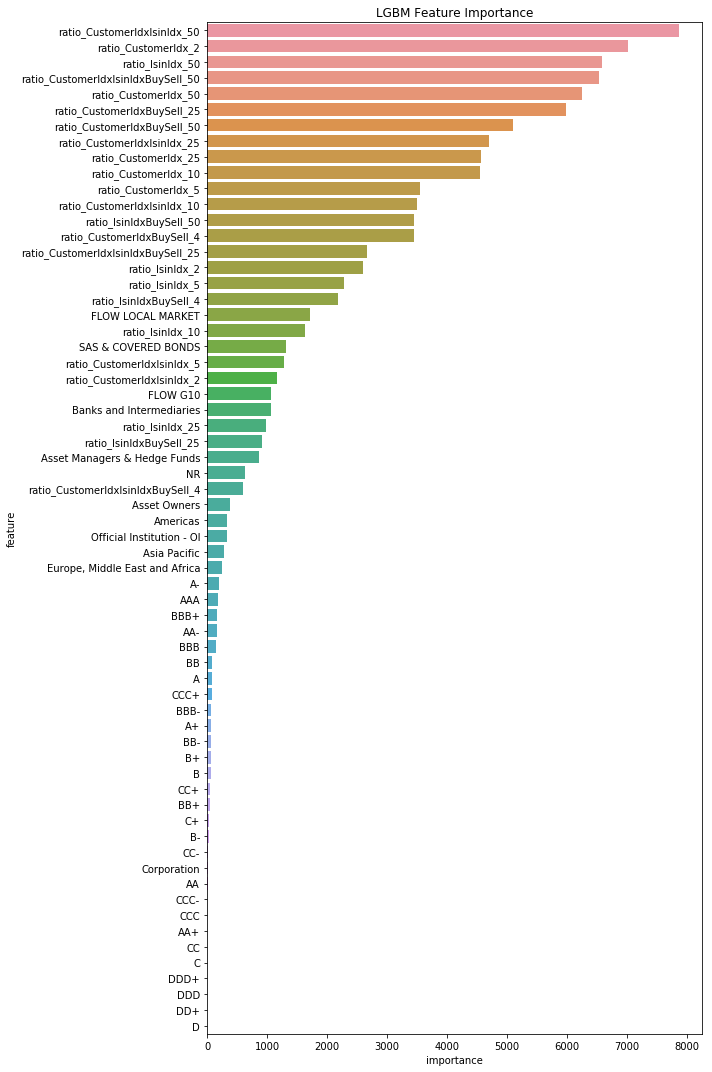

In [18]:
##### VARIABLE IMPORTANCE

# load variable importance
importance = pd.DataFrame()
importance["feature"] = features
importance["importance"] = gbm.feature_importances_

# plot variable importance
plt.figure(figsize = (10, 15))
sns.barplot(x = "importance", y = "feature", data = importance.sort_values(by = "importance", ascending = False))
plt.title('LGBM Feature Importance')
plt.tight_layout()

# 5. PREDICTIONS

In [19]:
# reload data
del train, valid
train = pd.read_csv("../data/prepared/train_new.csv")
test  = pd.read_csv("../data/prepared/test_new.csv")

In [20]:
# remove customer not present in test set
# this is just 2m out of 111m observations
customers = train.CustomerIdx.unique()
print(len(customers))
customers = [c for c in customers if c in test.CustomerIdx.unique()]
print(len(customers))
train = train[train.CustomerIdx.isin(customers)]
print("Train data:", train.shape)

3439
2495
Train data: (108965520, 45)


In [21]:
# data partitioning
stats = train[(train["Week"] >= 1) & (train["Week"] <= 50)]
train = train[(train["Week"] >= 51)]

In [22]:
# computing ratios
train = compute_all_ratios(stats, train)
test  = compute_all_ratios(train, test)
del stats

In [23]:
# randomly remove 495 customers to be faster
train = train[train.CustomerIdx.isin(subcust)]
print("Train data:", train.shape)

Train data: (52765720, 69)


In [24]:
# extract target
y_train = train.CustomerInterest

In [25]:
# list of features
exclude  = ["Week", "CustomerIdx", "IsinIdx", "BuySell", "CustomerInterest"]
features = [f for f in train.columns if f not in exclude]

In [26]:
# subset data
train = train[features]

In [27]:
# check shapes
print(train.shape)
print(test.shape)

(52765720, 64)
(484758, 71)


In [28]:
# lightGBM
gbm = lgb.LGBMClassifier(n_estimators     = num_iters,
                         learning_rate    = 0.005,
                         num_leaves       = 70,
                         colsample_bytree = 0.8,
                         subsample        = 0.9,
                         max_depth        = 7,
                         reg_alpha        = 0.1,
                         reg_lambda       = 0.1,
                         min_split_gain   = 0.01,
                         min_child_weight = 2,
                         random_state     = seed,
                         num_threads      = cores)

# train lightGBM
gbm = gbm.fit(train, y_train, 
              eval_set = [(train, y_train)], 
              eval_metric = metric, verbose = verbose)
    
# predict test
del train
test["CustomerInterest"] = gbm.predict_proba(test[features], num_iteration = num_iters)[:, 1]

[100]	training's auc: 0.676287
[200]	training's auc: 0.677007
[300]	training's auc: 0.677593
[400]	training's auc: 0.678537
[500]	training's auc: 0.679218
[600]	training's auc: 0.679967
[700]	training's auc: 0.680784
[800]	training's auc: 0.681803
[900]	training's auc: 0.682921
[1000]	training's auc: 0.684063
[1100]	training's auc: 0.685151
[1200]	training's auc: 0.686146
[1300]	training's auc: 0.687128
[1400]	training's auc: 0.687955


# 7. SUBMISSION

In [32]:
# export CSV
subm = test[["PredictionIdx", "CustomerInterest"]]
subm.to_csv("../submissions/0689451_lgb_ratios_dummies.csv", index = False, float_format = "%.8f")